In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df

In [2]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv")
hoyle_data = (
    hoyle_data[hoyle_data["task"]=="intrusions"]
    .drop(columns=[c for c in hoyle_data.columns if c[1]=="_"])
    .rename(columns={"dataset":"corpus", "topic_idx":"topic",
                     "human_idx":"rater", "scores_raw":"intrusion",
                     "confidences_raw":"confidence"})
    ).drop(columns=["task"])

In [3]:
corpus_ids = (hoyle_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (hoyle_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (hoyle_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

# topic_ids = (hoyle_data.groupby(["corpus", "model", "topic"], as_index=False)
#     .agg({"intrusion":"count"})
#     .drop(columns="intrusion"))
# topic_ids["topic_id"] = topic_ids.index 

rater_ids = (hoyle_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(hoyle_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
# Topic ids are no longer 0 - 299
# data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = d4.rename(columns={"topic" : "topic_id"})
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [4]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Model

In [5]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

In [6]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_topic = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}

In [7]:
np.ones(6).reshape(1,-1)

array([[1., 1., 1., 1., 1., 1.]])

In [8]:
# Topic only model

glm_topic["model"] = pm.Model()
with glm_topic["model"]:
    # Hyperparameter priors
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + za*sigma_a).mean(axis=1), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")
    
    glm_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 91 seconds.


In [9]:
glm_topic["summary_stat"] = create_summary_stat(glm_topic["trace"], stat_funcs={"crit_val":lambda x:(x<0).sum()/x.shape[0]})

/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/roger/anaconda3/envs/bayes_topic_measures/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) 

In [10]:
glm_topic["summary_stat"][glm_topic["summary_stat"]["param"]=="c_diff"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,crit_val
308,c_diff,"0, 0",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN,0.0000
309,c_diff,"0, 1",0.0934,0.0148,0.0660,0.1212,0.0002,0.0002,3946.9684,1244.2707,1.0003,0.0000
310,c_diff,"0, 2",0.0329,0.0138,0.0045,0.0561,0.0002,0.0002,4070.9484,1410.0074,1.0006,0.0075
311,c_diff,"0, 3",-0.0041,0.0145,-0.0315,0.0226,0.0002,0.0004,4880.6206,1303.4770,1.0020,0.6090
312,c_diff,"0, 4",0.0400,0.0147,0.0132,0.0690,0.0002,0.0002,3813.0740,1252.5088,0.9995,0.0045
313,c_diff,"0, 5",0.0279,0.0145,0.0007,0.0541,0.0002,0.0002,4801.7597,1464.7656,1.0001,0.0260
314,c_diff,"1, 0",-0.0934,0.0148,-0.1212,-0.0660,0.0002,0.0002,3946.9684,1244.2707,1.0003,1.0000
315,c_diff,"1, 1",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2000.0000,2000.0000,NaN,0.0000
316,c_diff,"1, 2",-0.0606,0.0145,-0.0872,-0.0333,0.0002,0.0002,4421.2663,1787.8064,1.0016,1.0000
317,c_diff,"1, 3",-0.0975,0.0156,-0.1259,-0.0687,0.0002,0.0002,4327.5178,1393.7382,1.0003,1.0000


In [13]:
glm_topic["summary_stat"]["param"].value_counts()

za         300
c_diff      36
c_mean       6
mu           1
sigma_a      1
Name: param, dtype: int64

In [11]:
cordel_ids

,corpus,model,cordel_id
0,nytimes,dvae,0
1,nytimes,etm,1
2,nytimes,mallet,2
3,wikitext,dvae,3
4,wikitext,etm,4
5,wikitext,mallet,5


AttributeError: 'AxesSubplot' object has no attribute 'set_yaxis'

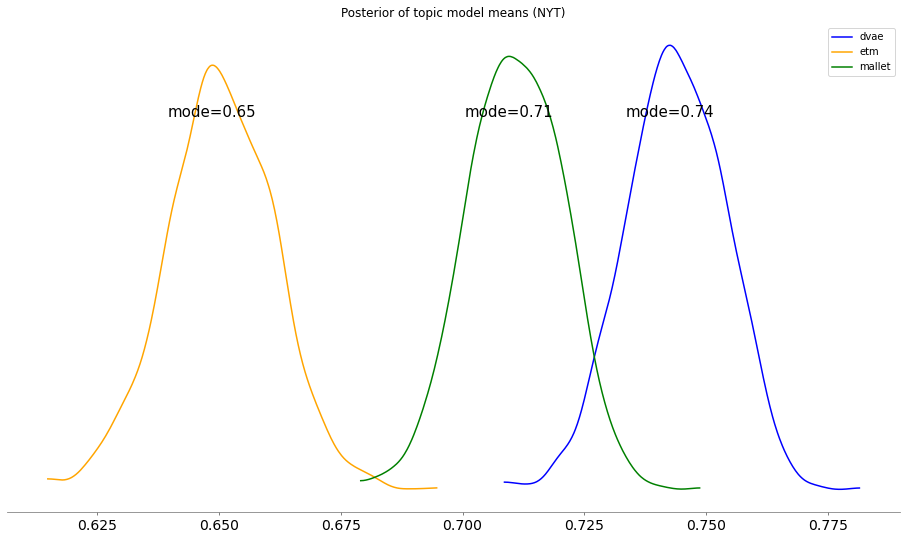

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(16,9))
for i, c in enumerate(["blue","orange","green"]):
    az.plot_posterior(glm_topic["trace"], var_names="c_mean", coords={"obs_id":[i]}, 
                      hdi_prob='hide',point_estimate="mode", ax=axs, color=c)
axs.legend(axs.get_lines(), ["dvae", "etm", "mallet"])
axs.set_title("Posterior of topic model means (NYT)")
axs.set_yaxis("")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16,9))
for i, c in enumerate(["blue","orange","green"]):
    az.plot_posterior(glm_topic["trace"], var_names="c_mean", coords={"obs_id":[i+3]}, 
                      hdi_prob='hide',point_estimate="mode", ax=axs, color=c)
axs.legend(axs.get_lines(), ["dvae", "etm", "mallet"])
axs.set_title("Posterior of topic model means (Wiki)")
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
# axs[0, 0].plot(x, y)

for pair in [(0,1),(0,2),(1,2)]:
    coord={"obs_id":[pair[0]], "c_diff_dim_1":[pair[1]]}
    az.plot_posterior(glm_topic["trace"], var_names="c_diff", coords=coord, 
                      ref_val=0, hdi_prob='hide',point_estimate=None, ax=axs[pair])


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
# axs[0, 0].plot(x, y)

for pair in [(3,4),(3,5),(4,5)]:
    coord={"obs_id":[pair[0]], "c_diff_dim_1":[pair[1]]}
    az.plot_posterior(glm_topic["trace"], var_names="c_diff", coords=coord, 
                      ref_val=0, hdi_prob='hide',point_estimate=None, ax=axs[pair[0]-3,pair[1]-3])


## Unit level data

In [9]:
# Rater, Topic model

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a).T).mean(axis=1), 
                              dims="obs_id")
    
    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
